<h2 style='color:blue'>Actividad 1</h2> 

1. Cargar el conjunto de datos de alguna de las señales de VDA que se ofrecen a continuación y graficarlo.
2. Entrenar diferentes modelos de Sugeno con todos ellos, variando la cantidad de reglas R (O el parámetro de radio de vecindad del clustering sustractivo, si corresponde). Graficar el error cuadrático medio (MSE) vs. R.
3. Elegir uno de los modelos según la mejor relación entre R y el MSE obtenido.
   Sobremuestrear la señal, barriendo la variable de entrada para tener muchos más valores de muestras que con los datos     originales y utilizando el modelo de Sugeno seleccionado.
4. Presentar todos los resultados y análisis en un documento (PDF o DOCX) y adjuntarlo. Puede presentarse un documento cada dos personas como máximo.

Nota: Las señales de Variación de Diámetro Arterial fueron muestreadas con una frecuencia de 400 Hz. Es posible graduar así un eje temporal en segundos. El intervalo entre muestras sería de 1/400 s = 2.5ms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Consigna 1

array([[5.250e-02, 6.620e+02],
       [3.100e-01, 4.780e+02],
       [3.650e-01, 4.560e+02],
       [1.875e-01, 5.550e+02],
       [1.025e-01, 5.650e+02],
       [1.975e-01, 5.510e+02],
       [2.050e-01, 5.440e+02],
       [2.500e-01, 4.940e+02],
       [1.725e-01, 5.610e+02],
       [3.200e-01, 4.720e+02],
       [1.300e-01, 5.600e+02],
       [1.625e-01, 5.630e+02],
       [3.350e-01, 4.610e+02],
       [7.000e-02, 5.970e+02],
       [1.650e-01, 5.620e+02],
       [1.700e-01, 5.620e+02],
       [1.500e-02, 4.950e+02],
       [2.575e-01, 4.910e+02],
       [3.150e-01, 4.750e+02],
       [3.700e-01, 4.550e+02],
       [2.825e-01, 4.960e+02],
       [3.500e-01, 4.580e+02],
       [6.500e-02, 6.150e+02],
       [3.075e-01, 4.800e+02],
       [1.750e-01, 5.600e+02],
       [5.000e-02, 6.690e+02],
       [2.350e-01, 5.070e+02],
       [7.750e-02, 5.750e+02],
       [8.500e-02, 5.620e+02],
       [2.325e-01, 5.090e+02],
       [2.000e-01, 5.480e+02]])

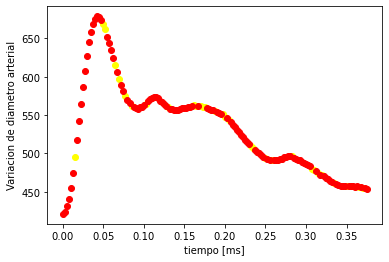

In [190]:
data = pd.read_csv('samplesVDA1.txt', sep=" ", header=None)
data.to_numpy()
from sklearn.model_selection import train_test_split

'''Nota: Las señales de Variación de Diámetro Arterial fueron muestreadas con una frecuencia de 400 Hz. 
Es posible graduar así un eje temporal en segundos. El intervalo entre muestras sería de 1/400 s = 2.5ms.
Tenemos en cuenta esto para graficar el eje x.
'''
N , features = data.shape
x = []
x1 = [ n * 1/400 for n in range(N)]

x1 =np.array(x1)
x1 = x1.reshape(-1,1)
data = np.concatenate( (x1,data) , axis = 1)
#plt.scatter(data[:,0],data[:,1], color = 'blue')
plt.xlabel('tiempo [ms]')
plt.ylabel('Variacion de diametro arterial')

#Estos son los datos al %100 vamos a aplicar early stopping para saber cuando el modelo deja de generalizar el problema
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(data,test_size=0.2, random_state = 25)
plt.scatter(testing_data[:,0],testing_data[:,1], color = 'yellow')
plt.scatter(training_data[:,0],training_data[:,1], color = 'red')

training_data
testing_data

In [191]:
from sklearn.preprocessing import MinMaxScaler
import time
from fcmeans import FCM

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii, n_reglas):
        my_model = FCM(n_clusters=n_reglas) 
        my_model.fit(data) 
        cluster_center = my_model.centers
        labels = my_model.predict(data)
        start_time = time.time()
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()
        


[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


(0.0, 20.0)

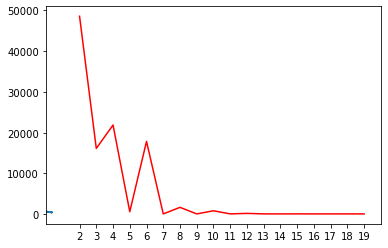

In [217]:
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

data_x = data[:,0]
data_y = data[:,1]

data_x = testing_data[:,0]
data_y = testing_data[:,1]

plt.plot(data_x, data_y)
# plt.ylim(-20,20)

data = np.vstack((data_x, data_y)).T

fis2 = fis()
errores = []
for i in range(2,20):
    fis2.genfis(data, 1.1 ,i)
    r = fis2.evalfis(np.vstack(data_x))
    error = (data[:,1] - r)**2
    mse = error.sum()
    errores.append(mse)
    
print(np.arange(2,20,1))
plt.plot(np.arange(2,20,1),errores , c = 'red')
plt.xticks(np.arange(2,20,1) , np.arange(2,20,1))
plt.xlim(0,20)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


(0.0, 20.0)

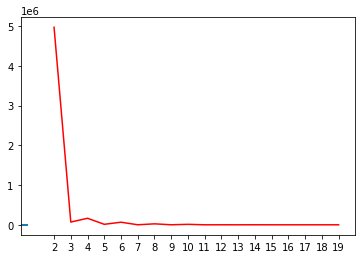

In [219]:
data_x = training_data[:,0]
data_y = training_data[:,1]

plt.plot(data_x, data_y)
# plt.ylim(-20,20)

data = np.vstack((data_x, data_y)).T

fis2 = fis()
errores = []
for i in range(2,20):
    fis2.genfis(data, 1.1 ,i)
    r = fis2.evalfis(np.vstack(data_x))
    error = (data[:,1] - r)**2
    mse = error.sum()
    errores.append(mse)
    
print(np.arange(2,20,1))
plt.plot(np.arange(2,20,1),errores , c = 'red')
plt.xticks(np.arange(2,20,1) , np.arange(2,20,1))
plt.xlim(0,20)